# Stock Market Analysis

## Business Problem

 - A stock market investor is looking to invest in a portfolio consisting of three technology companies, three healthcare companies, as well as one cryptocurrency for the next six month period. This notebook will analyze the top ten tech and healthcare stocks according to volume traded as well the top five cryptocurrency stocks by volume traded. The stocks will then be analyzed according to past future returns dating back to January 2016 as well as the stocks' volitility over that period. Price to earnings ratios (P/E ratios) will also be taken into account for the tech and healthcare stocks. A sarima model and Facebook Prophet model will then be run on each of the stocks in order to predict future returns over the next six month period. Model results will then be compared and analyzed, and portfolio investment reccomendations will then be provided based on the analysis. 

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandas_datareader
import pandas_datareader.data as web
import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from fbprophet import Prophet
import yfinance as yf
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def adfuller_of(series):
    
    """Prints the Augmented Dickey-Fuller test results."""    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                          ADF: {adf}
                      P-Value: {pvalue}
                     Used Lag: {usedlag}
       Number of Observations: {nobs}
    Critical Values (for ADF): {crit_vals}
                  ResultStore: {resstore}
    ''')

In [3]:
def get_data(stock):
    """Takes in a stock symbol and retuns a datframe of that stock with new Stock, Returns, and Cumulative Returns columns."""
    start = datetime.datetime(2016,1,1)
    end = datetime.datetime(2021,6,1)
    stock_df = web.DataReader(stock, 'yahoo', start, end)
    stock_df['Stock'] = stock
    stock_df['Returns'] = stock_df['Close'].pct_change(1)
    stock_df['Cumulative Return'] = (1 + stock_df['Returns']).cumprod()
    return stock_df

In [4]:
def autocor(stock_df):
    """Takes in a stock dataframe and returns a monthly autocorrelation plot of that stock."""
    monthly_df = stock_df.resample(rule='M').mean()
    plot_acf(monthly_df['Cumulative Return']);

In [5]:
def decomposition(stock):
    """Takes in a stock dataframe and returns a decomposition plot of that stock."""
    decomposition = seasonal_decompose(stock['Cumulative Return'].dropna(), period=365)
    fig = decomposition.plot()
    fig.set_size_inches(15,8)

In [6]:
def rolling_mean(stock, graph_title):
    stock['Cumulative Return'].rolling(180).mean().plot(figsize=(12,8))
    plt.title(graph_title)
    plt.ylabel('Cumulative Return %');

In [ ]:
def rolling_mean_comparison(df1, df2, df3, label1, label2, label3, graph_title):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(df1['Cumulative Return'].rolling(180).mean(), color='tab:blue', label=label1)
    ax.plot(df2['Cumulative Return'].rolling(180).mean(), color='tab:orange', label=label2)
    ax.plot(df3['Cumulative Return'].rolling(180).mean(), color='tab:green', label=label3)
    ax.legend()
    plt.title(graph_title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return %')
    fig.tight_layout()

In [7]:
def box_plot(stock1, stock2, stock3, title1, title2, title3, graph_title):
    box_df = pd.concat([stock1['Returns'], stock2['Returns'], stock3['Returns']], axis=1)
    box_df.columns = [title1, title2, title3]
    box_df.plot(kind='box', figsize=(12,8));
    plt.title(graph_title)

In [8]:
def returns_df(df):
    """Takes in a"""
    returns_lst = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        ret = stock_df.iloc[-1,8]
        returns_lst.append(round(ret,2)) 
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
    
    returns_dict = dict(zip(stock_names, returns_lst))
    returns_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Cumulative Return']) 
    sorted_df = returns_df.sort_values(by='Cumulative Return', ascending=False).reset_index(drop=True)
    return sorted_df

In [142]:
def plot_returns(df, title, graph_color):
    ax = df.sort_values('Cumulative Return').plot.bar(x='Stock', figsize=(12,8), color=graph_color)
    plt.title(title)
    plt.xlabel('Cumulative Return %')

In [10]:
def get_pe_ratio(stock):
    quote_table = si.get_quote_table(stock, dict_result=False)
    return quote_table.iloc[13]

In [11]:
def sarima_model_fcast(df, graph_title, graph_color):
    """Takes in a dataframe, runs a stepwise fit and SARIMA model on each stock and returns a dictionary of."""
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        monthly_df = stock_df.resample(rule='M').mean()
        train = monthly_df['Cumulative Return'].iloc[:54]
        stepwise_fit = auto_arima(train)
        model_order = stepwise_fit.order
        future_model = SARIMAX(monthly_df['Cumulative Return'], order=model_order, seasonal_order=(1,1,0,7))
        results_future = future_model.fit()
        fcast = results_future.predict(len(monthly_df), len(monthly_df)+6, typ='levels').rename('SARIMA Forecast')
        fcast_df = pd.DataFrame(fcast)
        ret = fcast_df.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Fcast Cumulative Return']) 
    ax = fcast_df.sort_values('Fcast Cumulative Return').plot.barh(x='Stock', figsize=(12,8), color=graph_color)
    plt.title(graph_title)
    plt.xlabel('Cumulative Return %')

In [12]:
def sarima_fcast_df(df):
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        monthly_df = stock_df.resample(rule='M').mean()
        train = monthly_df['Cumulative Return'].iloc[:54]
        stepwise_fit = auto_arima(train)
        model_order = stepwise_fit.order
        future_model = SARIMAX(monthly_df['Cumulative Return'], order=model_order, seasonal_order=(1,1,0,7))
        results_future = future_model.fit()
        fcast = results_future.predict(len(monthly_df), len(monthly_df)+6, typ='levels').rename('SARIMA Forecast')
        fcast_df = pd.DataFrame(fcast)
        ret = fcast_df.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Fcast Cumulative Return']) 
    sorted_df = fcast_df.sort_values(by='Fcast Cumulative Return', ascending=False).reset_index(drop=True)
    return sorted_df

In [13]:
def plot_train_pred(stock_df, graph_title):

    monthly_df = stock_df.resample(rule='M').mean()

    train = monthly_df.iloc[:54]['Cumulative Return']
    test = monthly_df.iloc[54:]['Cumulative Return']

    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order

    model = SARIMAX(train, order=model_order, seasonal_order=(1,1,0,7))
    results = model.fit()

    train_start = train.index.min()
    train_end = train.index.max()

    predictions = results.predict(start=train_start, end=train_end, typ='levels').rename('SARIMA Predictions')

    train.plot(legend=True, figsize=(12,8))
    predictions.plot(legend=True)
    plt.ylabel('Cumulative Return %')
    plt.title(graph_title)

In [14]:
def plot_test_pred(stock_df, graph_title):

    monthly_df = stock_df.resample(rule='M').mean()

    train = monthly_df.iloc[:54]['Cumulative Return']
    test = monthly_df.iloc[54:]['Cumulative Return']

    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order

    model = SARIMAX(train, order=model_order, seasonal_order=(1,1,0,7))
    results = model.fit()

    test_start = test.index.min()
    test_end = test.index.max()

    test_predictions = results.predict(start=test_start, end=test_end, typ='levels').rename('SARIMA Predictions')

    test.plot(legend=True, figsize=(12,8))
    test_predictions.plot(legend=True)
    plt.ylabel('Cumulative Return %')
    plt.title(graph_title)

In [170]:
def model_rmse(stock_df):

    resampled = stock_df.resample(rule='M').mean()

    train = resampled.iloc[:54]['Cumulative Return']
    test = resampled.iloc[54:]['Cumulative Return']

    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order

    model = SARIMAX(train, order=model_order, seasonal_order=(1,1,0,7))
    results = model.fit()

    test_start = test.index.min()
    test_end = test.index.max()

    test_predictions = results.predict(start=test_start, end=test_end, typ='levels').rename('SARIMA Predictions')
    error = round(rmse(test, test_predictions),2)
    test_mean = round(test.mean(),2)
    
    print(f'RMSE: {error} Test Mean: {test_mean}')

In [171]:
def prophet_rmse(stock_df):
    stock_returns = pd.DataFrame(stock_df['Cumulative Return'])
    monthly_returns = stock_returns.resample(rule='M').mean()
    monthly_returns.reset_index(inplace=True)
    monthly_returns.columns = ['ds', 'y']
    monthly_returns['ds'] = pd.to_datetime(monthly_returns['ds'])
    train = monthly_returns[:54]
    test = monthly_returns[54:]
    
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods=18, freq='M')
    
    forecast = m.predict(future)
    predictions = forecast.iloc[-12:]['yhat']
    error = round(rmse(predictions, test['y']),2)
    test_mean = round(test['y'].mean(),2)
    
    print(f'RMSE: {error} Test Mean: {test_mean}')

In [16]:
def plot_fcast(stock_df, graph_title):
    monthly_df = stock_df.resample(rule='M').mean()
    train = monthly_df.iloc[:54]['Cumulative Return']
    stepwise_fit = auto_arima(train)
    model_order = stepwise_fit.order
    future_model = SARIMAX(monthly_df['Cumulative Return'], order=model_order, seasonal_order=(1,1,0,7))
    results_future = future_model.fit()
    fcast = results_future.predict(len(monthly_df), len(monthly_df)+6, typ='levels').rename('SARIMA Forecast')
    conf_int = results_future.get_forecast(6)
    fcast_ci = conf_int.conf_int(alpha=0.05).rename(columns={'lower Cumulative Return':'Lower 95% Confidence Interval','upper Cumulative Return':'Upper 95% Confidence Interval'})
    fcast_ci.plot(linestyle='dotted')
    monthly_df['Cumulative Return'].plot(legend=True, figsize=(12,8))
    fcast.plot(legend=True)
    plt.ylabel('Cumulative Return %')
    plt.title(graph_title);

In [17]:
def fb_prophet_model(df, graph_title, graph_color):
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        returns_df = pd.DataFrame(stock_df['Cumulative Return'])
        monthly_df = returns_df.resample(rule='M').mean()
        monthly_df.reset_index(inplace=True)
        monthly_df.columns = ['ds', 'y']
        monthly_df['ds'] = pd.to_datetime(monthly_df['ds'])
        train = monthly_df[:54]
        test = monthly_df[54:]
        m = Prophet()
        m.fit(train)
        future = m.make_future_dataframe(periods=18, freq='M')
        forecast = m.predict(future)
        ret = forecast.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Fcast Cumulative Return']) 
    ax = fcast_df.sort_values('Fcast Cumulative Return').plot.barh(x='Stock', figsize=(12,8), color=graph_color)
    plt.title(graph_title)
    plt.xlabel('Cumulative Return %')

In [18]:
def fb_prophet_df(df):
    forecasted_returns = []
    for s in df.Stock.unique():
        stock_df = df[(df['Stock'] == s)]
        returns_df = pd.DataFrame(stock_df['Cumulative Return'])
        monthly_df = returns_df.resample(rule='M').mean()
        monthly_df.reset_index(inplace=True)
        monthly_df.columns = ['ds', 'y']
        monthly_df['ds'] = pd.to_datetime(monthly_df['ds'])
        train = monthly_df[:54]
        test = monthly_df[54:]
        m = Prophet()
        m.fit(train)
        future = m.make_future_dataframe(periods=18, freq='M')
        forecast = m.predict(future)
        ret = forecast.iloc[-1,-1]
        forecasted_returns.append(round(ret,2))
        
    stock_names = []
    for n in df.Stock.unique():
        stock_names.append(n)
            
    returns_dict = dict(zip(stock_names, forecasted_returns))
    fcast_df = pd.DataFrame(list(returns_dict.items()),columns = ['Stock','Prophet Fcast Cumulative Return']) 
    sorted_df = fcast_df.sort_values(by='Prophet Fcast Cumulative Return', ascending=False).reset_index(drop=True)
    return sorted_df

In [20]:
def plot_prophet_test_fcast(stock_df, graph_title):
    stock_returns = pd.DataFrame(stock_df['Cumulative Return'])
    monthly_returns = stock_returns.resample(rule='M').mean()
    monthly_returns.reset_index(inplace=True)
    monthly_returns.columns = ['ds', 'y']
    monthly_returns['ds'] = pd.to_datetime(monthly_returns['ds'])
    train = monthly_returns[:54]
    test = monthly_returns[54:]
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods=18, freq='M')
    forecast = m.predict(future)
    ax = forecast.plot(x='ds', y ='yhat', label='Predictions', legend=True, figsize=(12,8))
    test.plot(x='ds', y='y', label='True Test Data', legend=True, ax=ax, xlim=('2020-07-31', '2021-12-01'))
    plt.title(graph_title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return %');

In [21]:
def plot_prophet_fcast(stock_df):
    stock_returns = pd.DataFrame(stock_df['Cumulative Return'])
    monthly_returns = stock_returns.resample(rule='M').mean()
    monthly_returns.reset_index(inplace=True)
    monthly_returns.columns = ['ds', 'y']
    monthly_returns['ds'] = pd.to_datetime(monthly_returns['ds'])
    train = monthly_returns[:54]
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods=18, freq='M')
    forecast = m.predict(future)
    m.plot(forecast);

## Load Data/Data Description

 - The stock data used for this project is from the Yahoo Finance API. The top 10 stocks with at least 5 years of trading data, according to volume traded in the technology and healthcare sectors will be analyzed. Also the top 5 cryptocurrency stocks with at least 5 years of trading data, according to volume traded will also be analyzed. The start date for the stocks is January 1st, 2016 and the end date is June 1st, 2021. The stocks will then be broken up into individual dataframes as well as combined into three seperate dataframes according to sector. The stocks are formated into daily data and provides the following features: "High", "Low", "Open", "Close", "Volume", and "Adj Close". An additional column for "Stock" (name), "Returns", and "Cumulative Returns" will also be added onto the data for analysis.    

### Top 10 Tech Stocks by Volume

In [22]:
apple = get_data('AAPL')

In [162]:
apple.shape

(1362, 9)

In [23]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1362 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               1362 non-null   float64
 1   Low                1362 non-null   float64
 2   Open               1362 non-null   float64
 3   Close              1362 non-null   float64
 4   Volume             1362 non-null   float64
 5   Adj Close          1362 non-null   float64
 6   Stock              1362 non-null   object 
 7   Returns            1361 non-null   float64
 8   Cumulative Return  1361 non-null   float64
dtypes: float64(8), object(1)
memory usage: 106.4+ KB


In [24]:
apple.head()

,High,Low,Open,Close,Volume,Adj Close,Stock,Returns,Cumulative Return
Date,,,,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,24.323219,AAPL,NaN,NaN
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,23.713696,AAPL,-0.025059,0.974941
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,23.249626,AAPL,-0.019570,0.955861
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,22.268383,AAPL,-0.042205,0.915520
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,22.386133,AAPL,0.005288,0.920361


In [25]:
microsoft = get_data('MSFT')

In [26]:
google = get_data('GOOG')

In [27]:
amazon = get_data('AMZN')

In [28]:
facebook = get_data('FB')

In [29]:
tencent = get_data('TCEHY')

In [30]:
alibaba = get_data('BABA')

In [31]:
tesla = get_data('TSLA')

In [32]:
tsmc = get_data('TSM')

In [33]:
nvidia = get_data('NVDA')

In [34]:
#Combine Tech stocks into singular dataframe for analysis
to_concat = [apple, microsoft, google, amazon, facebook, tencent, alibaba, tesla, tsmc, nvidia]
tech_df = pd.concat(to_concat)

In [35]:
tech_df.shape

(13620, 9)

In [36]:
tech_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13620 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               13620 non-null  float64
 1   Low                13620 non-null  float64
 2   Open               13620 non-null  float64
 3   Close              13620 non-null  float64
 4   Volume             13620 non-null  float64
 5   Adj Close          13620 non-null  float64
 6   Stock              13620 non-null  object 
 7   Returns            13610 non-null  float64
 8   Cumulative Return  13610 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


### Top 10 Healthcare Stocks by Volume

In [37]:
united_health = get_data('UNH')

In [38]:
cvs = get_data('CVS')

In [39]:
hca = get_data('HCA')

In [40]:
mckesson = get_data('MCK')

In [41]:
amerisource_bergen = get_data('ABC')

In [42]:
cerner = get_data('CERN')

In [43]:
teladoc_health = get_data('TDOC')

In [44]:
bio_rad = get_data('BIO')

In [45]:
cardinal_health = get_data('CAH')

In [46]:
perkin_elmer = get_data('PKI')

In [47]:
#Combine Healthcare stocks into singular dataframe for analysis
to_concat = [united_health, cvs, hca, mckesson, amerisource_bergen, cerner, teladoc_health,
            bio_rad, cardinal_health, perkin_elmer]
healthcare_df = pd.concat(to_concat)

In [48]:
healthcare_df.shape

(13620, 9)

In [49]:
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13620 entries, 2016-01-04 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               13620 non-null  float64
 1   Low                13620 non-null  float64
 2   Open               13620 non-null  float64
 3   Close              13620 non-null  float64
 4   Volume             13620 non-null  float64
 5   Adj Close          13620 non-null  float64
 6   Stock              13620 non-null  object 
 7   Returns            13610 non-null  float64
 8   Cumulative Return  13610 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


### Top 5 Cryptocurrency Stocks by Volume

In [50]:
bitcoin = get_data('BTC-USD')

In [51]:
ethereum = get_data('ETH-USD')

In [52]:
dogecoin = get_data('DOGE-USD')

In [53]:
xrp = get_data('XRP-USD')

In [54]:
litecoin = get_data('LTC-USD')

In [55]:
#Combine Cryptocurrencies into singular dataframe for analysis
to_concat = [bitcoin, ethereum, dogecoin, xrp, litecoin]
crypto_df = pd.concat(to_concat)

In [56]:
crypto_df.shape

(9880, 9)

In [59]:
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9880 entries, 2016-01-01 to 2021-06-01
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               9880 non-null   float64
 1   Low                9880 non-null   float64
 2   Open               9880 non-null   float64
 3   Close              9880 non-null   float64
 4   Volume             9880 non-null   float64
 5   Adj Close          9880 non-null   float64
 6   Stock              9880 non-null   object 
 7   Returns            9875 non-null   float64
 8   Cumulative Return  9875 non-null   float64
dtypes: float64(8), object(1)
memory usage: 771.9+ KB


## Data Exploration

 - Will check the autocorrelation, decomposition, stationarity of the top stock in each industry in order to get a better feel for the data. Will also analyze the the past 5 year returns of the top stocks, as well as check the volilitilty of the top stocks in each sector, and the P/E ratios of the Tech and Healthcare stocks in order to gather further information in making portfolio recommendations.  

### Autocorrelation Analysis

 - Check the autocorrelation of the top stock in each sector for analysis.

In [ ]:
#Set graph style
plt.style.use('fivethirtyeight')

#### Apple Autocorrelation Graph

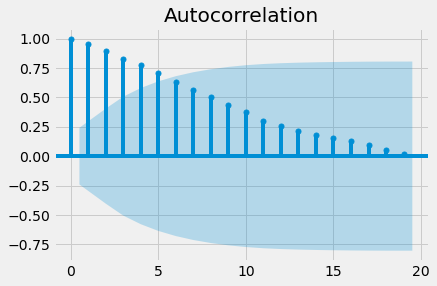

In [61]:
autocor(apple)

 - Apple appears to be autocorrelated up to about 6 lags.

#### United Health Autocorrelation Graph

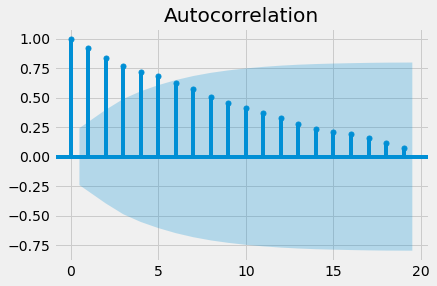

In [62]:
autocor(united_health)

 - United Health appears to be autocorrelated up to about 6 lags.

#### Bitcoin Autocorrelation Graph

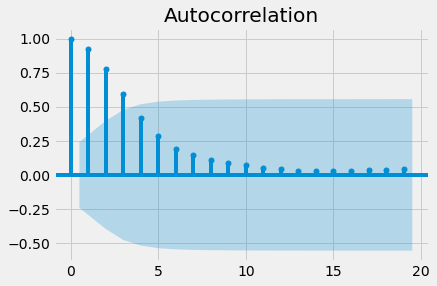

In [63]:
autocor(bitcoin)

 - Bitcoin appears to be autocorrelated up to about 3.5 lags.

### Decomposition Analysis

 - Will run a decomposition on the top stock in each sector in order to check for trends and seasonality as well as the residuals or noise in the data.

#### Apple Decomposition Graph

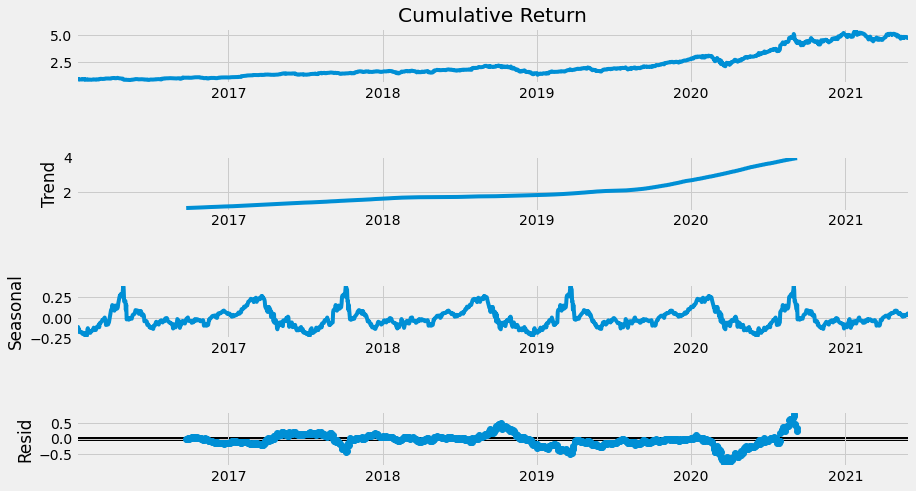

In [64]:
decomposition(apple)

 - Apple appears to following a general upward trend which appears to be increasing since late 2019. Apple also appears to have a seasonal component with spikes during the early and late parts of the year.

#### United Health Decomposition Graph

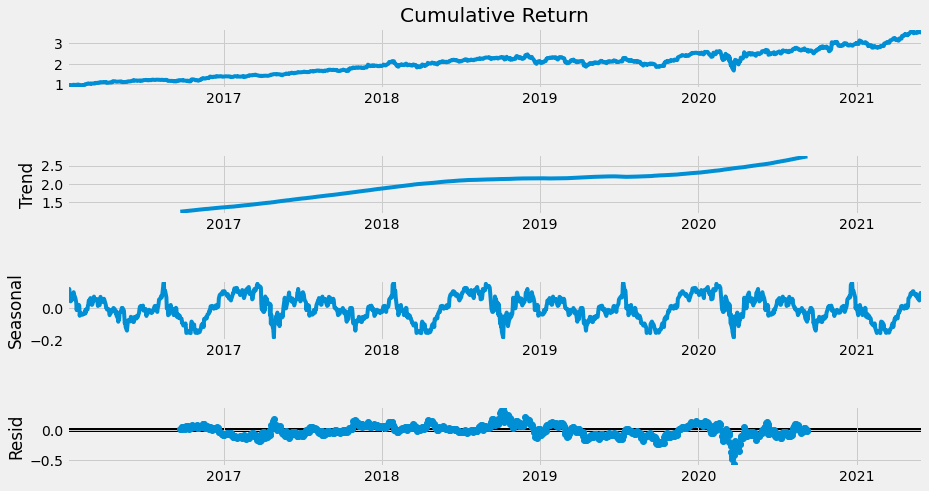

In [65]:
decomposition(united_health)

 - United Health appears to follow a steady upward trend. It also appears to be very seasonal with spikes occuring in many instances throughout the year.

#### Bitcoin Decomposition Graph

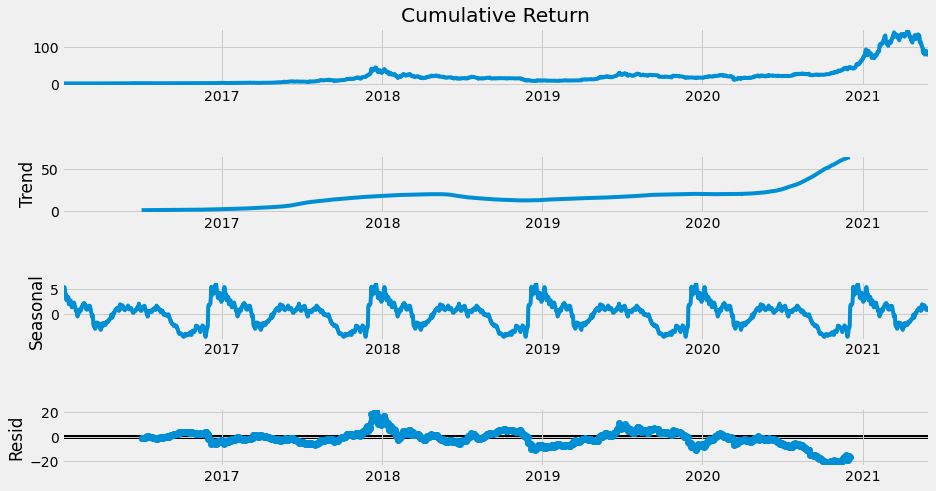

In [66]:
decomposition(bitcoin)

 - Bitcoin appears to have a very flat trend which only begins to increase recently in mid-2020. It also appears to follow a fairly steady seasonal pattern of sharply increasing late in each year before steadily declining again.

### Stationarity Analysis

 - Will run a Dickey Fuller Test on the top stock in each sector in order to check for stationarity.

In [67]:
#Apple check for stationarity
adfuller_of(apple['Cumulative Return'].dropna())


                          ADF: 0.10938559461024142
                      P-Value: 0.9666960808257994
                     Used Lag: 20
       Number of Observations: 1340
    Critical Values (for ADF): {'1%': -3.4352394560472033, '5%': -2.863699314925706, '10%': -2.567919624081087}
                  ResultStore: -4039.235993043869
    


- Adfuller test shows a p-value of .97. This is above the .05 threshold, meaning we can accept the null hypothesis that the Apple data is not stationary. 

In [68]:
#United Health check for stationarity
adfuller_of(united_health['Cumulative Return'].dropna())


                          ADF: 0.06250751966983592
                      P-Value: 0.9634060972570134
                     Used Lag: 14
       Number of Observations: 1346
    Critical Values (for ADF): {'1%': -3.4352176187736463, '5%': -2.863689678838957, '10%': -2.567914492514279}
                  ResultStore: -5025.356261266215
    


- Adfuller test shows a p-value of .96. This is above the .05 threshold, meaning we can accept the null hypothesis that the United Health data is not stationary. 

In [69]:
#Bitcoin check for stationarity
adfuller_of(bitcoin['Cumulative Return'].dropna())


                          ADF: -0.8878345863301812
                      P-Value: 0.7919522591364432
                     Used Lag: 26
       Number of Observations: 1948
    Critical Values (for ADF): {'1%': -3.4337113644639197, '5%': -2.863024848081541, '10%': -2.5675604733017385}
                  ResultStore: 7184.128895183861
    


- Adfuller test shows a p-value of .79. This is above the .05 threshold, meaning we can accept the null hypothesis that the Bitcoin data is not stationary. 

### Rolling Mean Analysis

 - Will run a 6 month rolling mean graph in order to check the 6 month trend. This could be helpful for portfolio recommendations since we are trying to predict 6 months into the future.

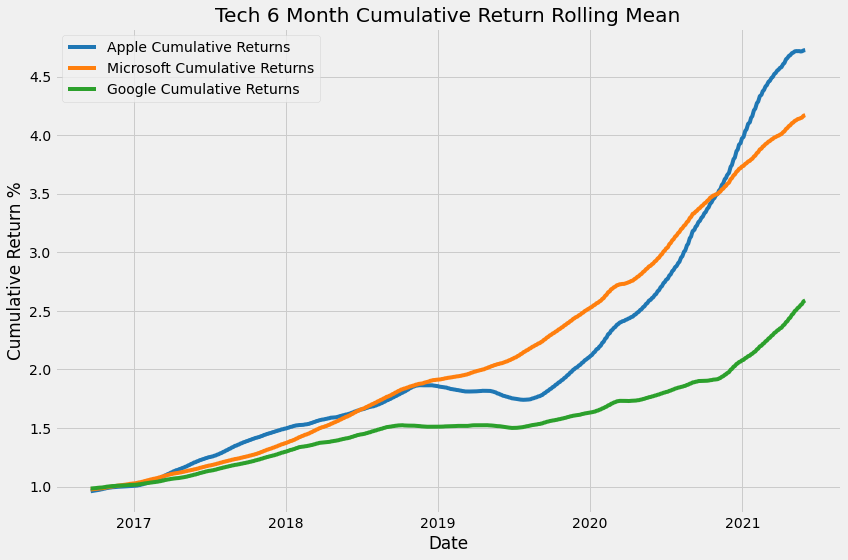

In [196]:
rolling_mean_comparison(apple, microsoft, google, 'Apple Cumulative Returns','Microsoft Cumulative Returns',
                       'Google Cumulative Returns','Tech 6 Month Cumulative Return Rolling Mean')

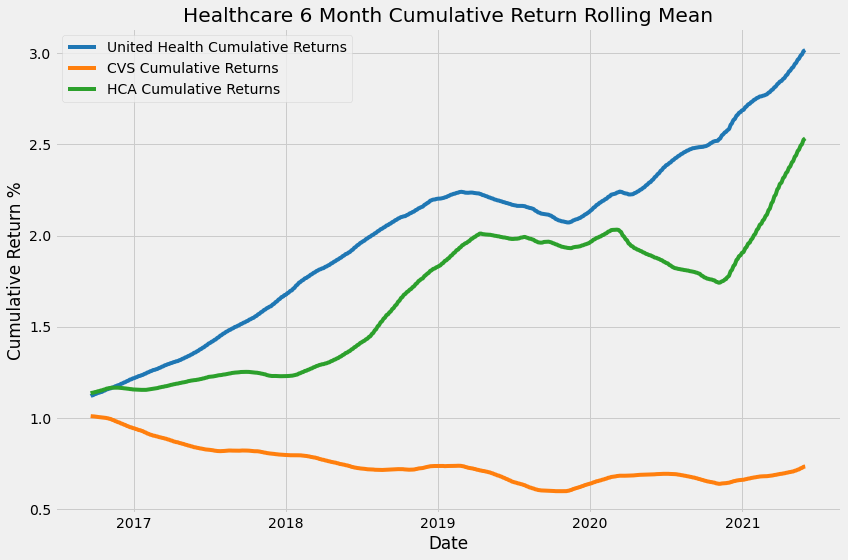

In [197]:
rolling_mean_comparison(united_health, cvs, hca, 'United Health Cumulative Returns','CVS Cumulative Returns',
                       'HCA Cumulative Returns','Healthcare 6 Month Cumulative Return Rolling Mean')

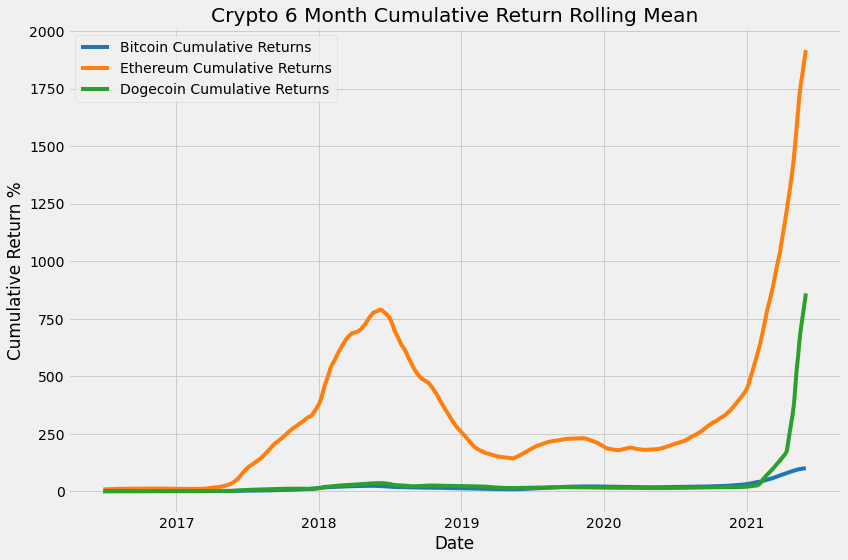

In [198]:
rolling_mean_comparison(bitcoin, ethereum, dogecoin, 'Bitcoin Cumulative Returns','Ethereum Cumulative Returns',
                       'Dogecoin Cumulative Returns','Crypto 6 Month Cumulative Return Rolling Mean')

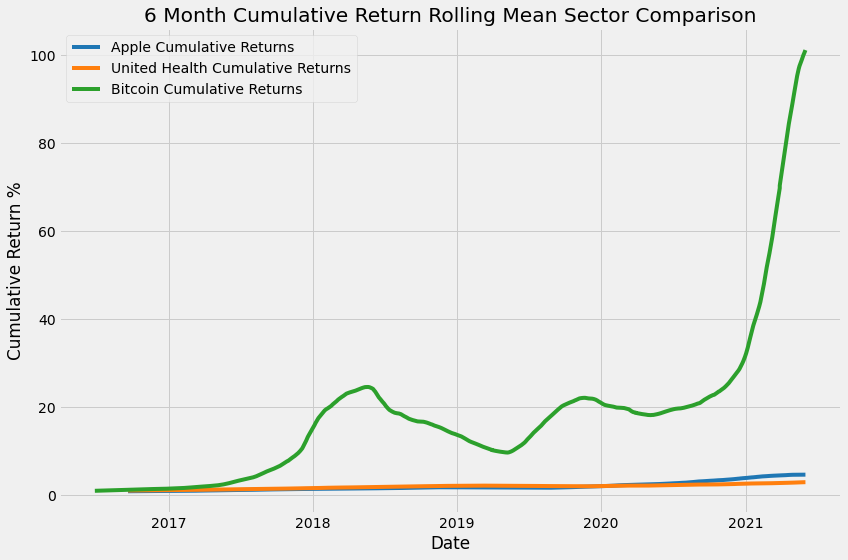

In [199]:
rolling_mean_comparison(apple, united_health, bitcoin, 'Apple Cumulative Returns','United Health Cumulative Returns',
                       'Bitcoin Cumulative Returns','6 Month Cumulative Return Rolling Mean Sector Comparison')

### Volatility Analysis

 - Will plot the returns of stocks into histograms as well as box plot to get an idea of the volitility of the stocks. The more volitile the stock, the more risky of an investment it will be over the next 6 month period. This will be taken into consideration when making portfolio recommendations.

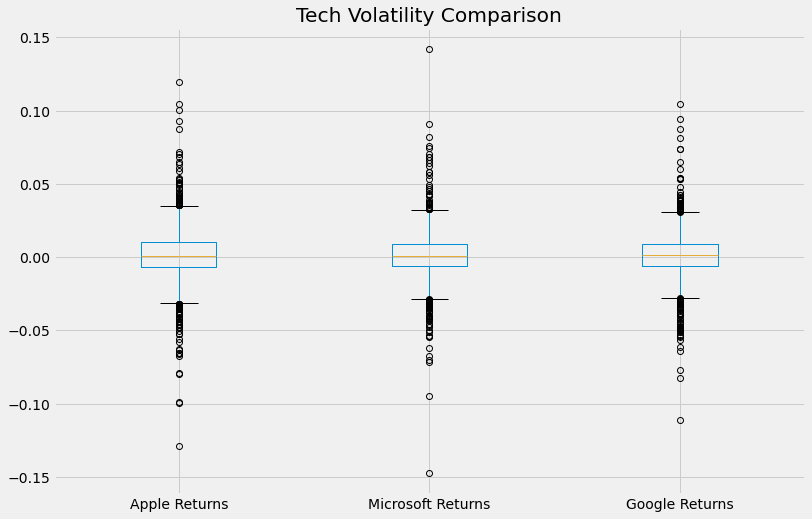

In [190]:
box_plot(apple, microsoft, google, 'Apple Returns', 'Microsoft Returns', 'Google Returns', 'Tech Volatility Comparison')

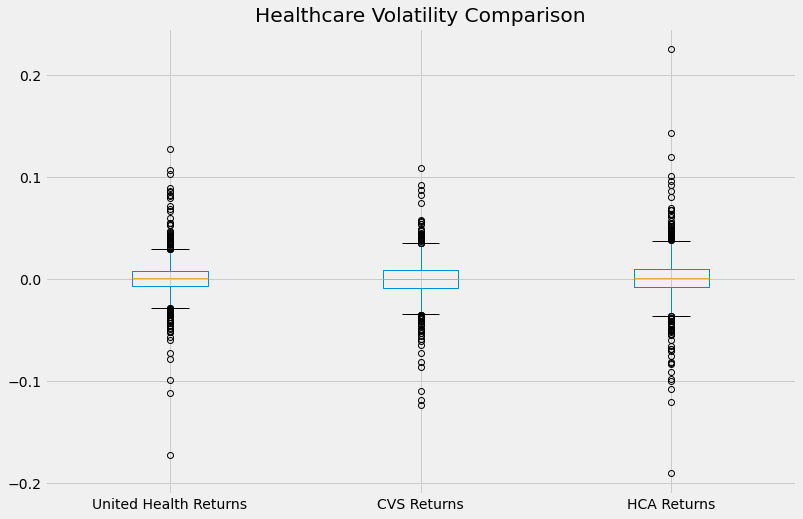

In [191]:
box_plot(united_health, cvs, hca, 'United Health Returns', 'CVS Returns', 'HCA Returns', 'Healthcare Volatility Comparison')

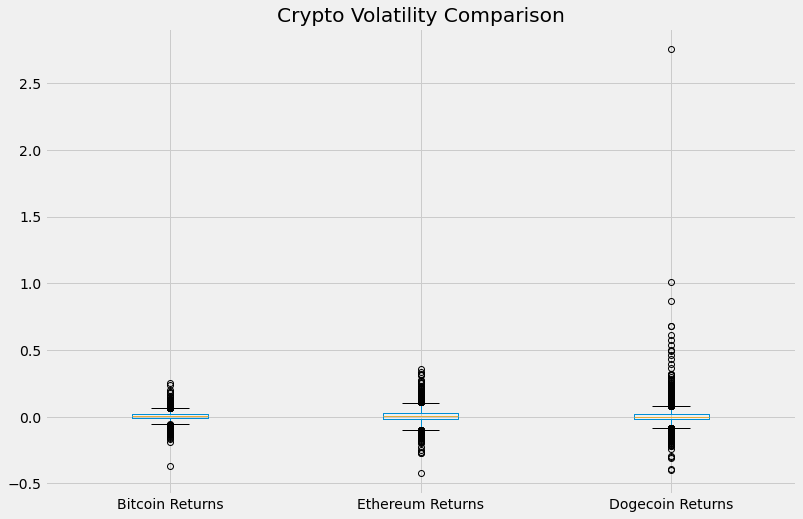

In [192]:
box_plot(bitcoin, ethereum, dogecoin, 'Bitcoin Returns', 'Ethereum Returns', 'Dogecoin Returns', 'Crypto Volatility Comparison')

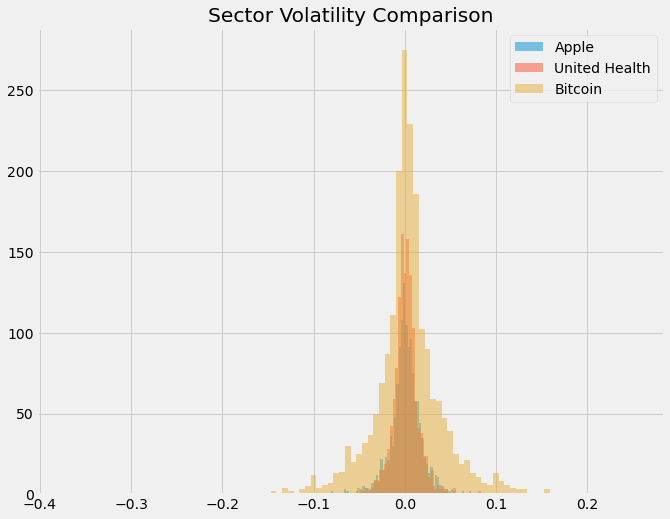

In [200]:
apple['Returns'].hist(bins=100, label='Apple', figsize=(10,8), alpha=0.5)
united_health['Returns'].hist(bins=100, label='United Health', figsize=(10,8), alpha=0.5)
bitcoin['Returns'].hist(bins=100, label='Bitcoin', figsize=(10,8), alpha=0.5)
plt.title('Sector Volatility Comparison')
plt.legend();

### Volatility Analysis Conclusions

### 5 Year Cumulative Returns Analysis

 - Will check the cumulative returns over the past 5 year period in order to get an idea of the highest and lowest performing stocks over that time period.

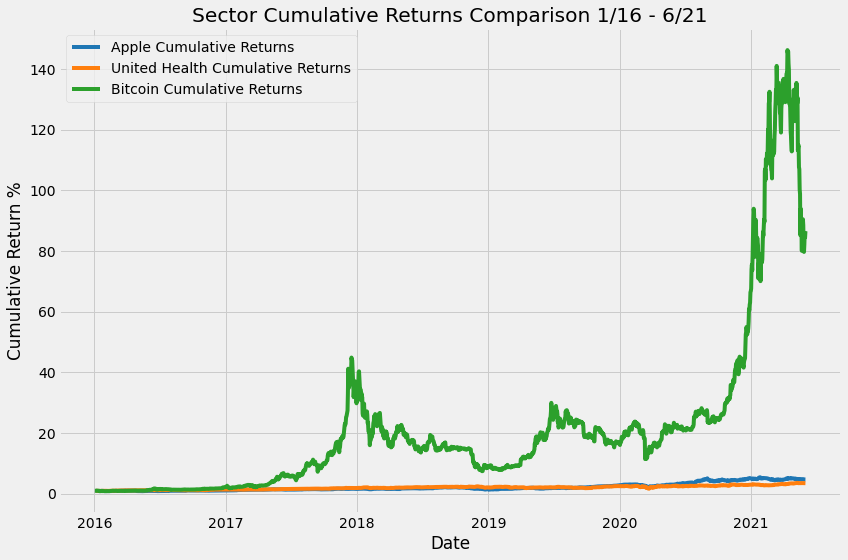

In [201]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(apple['Cumulative Return'], color='tab:blue', label='Apple Cumulative Returns')
ax.plot(united_health['Cumulative Return'], color='tab:orange', label='United Health Cumulative Returns')
ax.plot(bitcoin['Cumulative Return'], color='tab:green', label='Bitcoin Cumulative Returns')
ax.legend()
plt.title('Sector Cumulative Returns Comparison 1/16 - 6/21')
plt.xlabel('Date')
plt.ylabel('Cumulative Return %')
fig.tight_layout()

In [78]:
tech_returns_df = returns_df(tech_df)
tech_returns_df

,Stock,Cumulative Return
0,NVDA,20.10
1,TSLA,13.96
2,TSM,5.36
3,AMZN,5.05
4,AAPL,4.72
5,MSFT,4.51
6,TCEHY,4.25
7,GOOG,3.28
8,FB,3.22
9,BABA,2.86


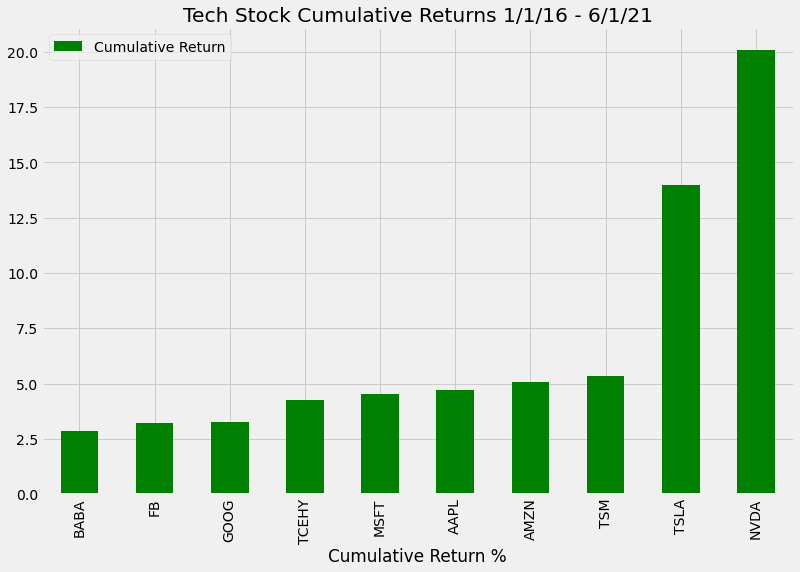

In [143]:
plot_returns(tech_returns_df, 'Tech Stock Cumulative Returns 1/1/16 - 6/1/21', 'g')

In [80]:
health_returns_df = returns_df(healthcare_df)
health_returns_df

,Stock,Cumulative Return
0,TDOC,8.47
1,BIO,4.27
2,UNH,3.49
3,HCA,3.26
4,PKI,2.70
5,CERN,1.34
6,ABC,1.12
7,MCK,0.99
8,CVS,0.89
9,CAH,0.63


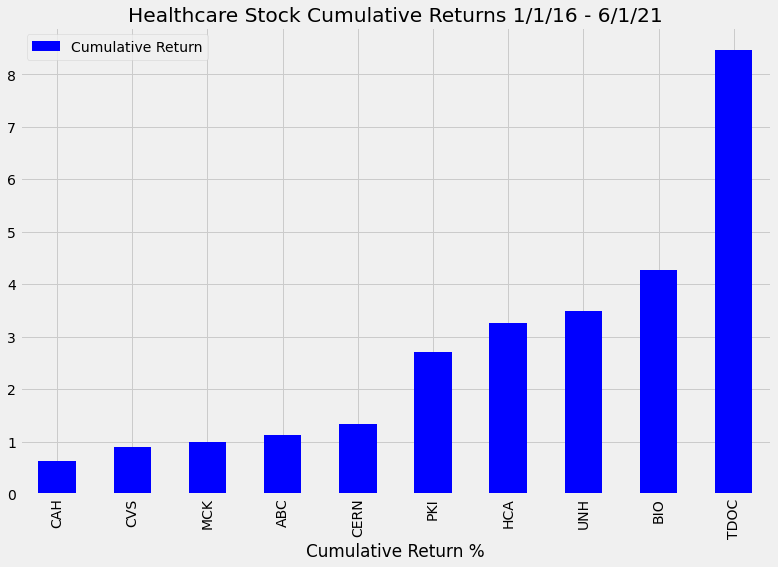

In [144]:
plot_returns(health_returns_df, 'Healthcare Stock Cumulative Returns 1/1/16 - 6/1/21', 'b')

In [82]:
crypto_returns_df = returns_df(crypto_df)
crypto_returns_df 

,Stock,Cumulative Return
0,ETH-USD,2854.49
1,DOGE-USD,2749.18
2,XRP-USD,172.02
3,BTC-USD,86.51
4,LTC-USD,53.37


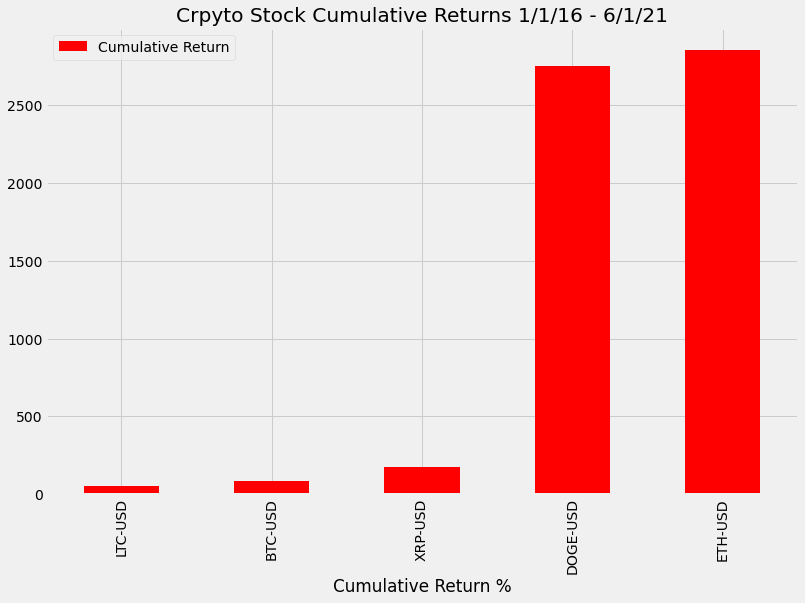

In [145]:
plot_returns(crypto_returns_df, 'Crpyto Stock Cumulative Returns 1/1/16 - 6/1/21', 'r')

In [84]:
to_concat = [tech_returns_df, health_returns_df, crypto_returns_df]
returns_comparison = pd.concat(to_concat)
returns_comparison.reset_index(drop=True, inplace=True)
returns_comparison.sort_values(by='Cumulative Return', ascending=False)

,Stock,Cumulative Return
20,ETH-USD,2854.49
21,DOGE-USD,2749.18
22,XRP-USD,172.02
23,BTC-USD,86.51
24,LTC-USD,53.37
0,NVDA,20.10
1,TSLA,13.96
10,TDOC,8.47
2,TSM,5.36
3,AMZN,5.05


### P/E Ratio Analysis

 - Will check the Price/Earnings ratio of the top three stocks in the tech and healthcare sectors for analysis. Because cryptocurrencies do not have a P/E ratio, they will be excluded from this analysis.

In [85]:
#Apple P/E Ratio
get_pe_ratio('AAPL')

attribute    PE Ratio (TTM)
value                 29.27
Name: 13, dtype: object

In [86]:
#Microsoft P/E Ratio
get_pe_ratio('MSFT')

attribute    PE Ratio (TTM)
value                 35.24
Name: 13, dtype: object

In [87]:
#Google P/E Ratio
get_pe_ratio('GOOG')

attribute    PE Ratio (TTM)
value                 33.52
Name: 13, dtype: object

 - All three Tech P/E ratios are within close range of each other with no significant outliers.  

In [88]:
get_pe_ratio('UNH')

attribute    PE Ratio (TTM)
value                 22.78
Name: 13, dtype: object

In [89]:
get_pe_ratio('CVS')

attribute    PE Ratio (TTM)
value                 15.21
Name: 13, dtype: object

In [90]:
get_pe_ratio('HCA')

attribute    PE Ratio (TTM)
value                 15.56
Name: 13, dtype: object

 - All three Healthcare P/E ratios are within close range of each other with no significant outliers. 

 - Will re-visit P/E ratio analysis before making final portfolio recommendations.

## Modeling

 - Will run a SARIMA and Facebook Prophet Model on each stock in order to get 6 month forecasted Cumulative Return Predictions.

### Tech SARIMA Models

In [91]:
tech_fcast = sarima_fcast_df(tech_df)
tech_fcast

,Stock,Fcast Cumulative Return
0,NVDA,25.83
1,TSLA,19.48
2,TSM,6.98
3,AMZN,5.93
4,AAPL,5.84
5,MSFT,5.43
6,TCEHY,4.86
7,GOOG,4.13
8,FB,3.73
9,BABA,3.02


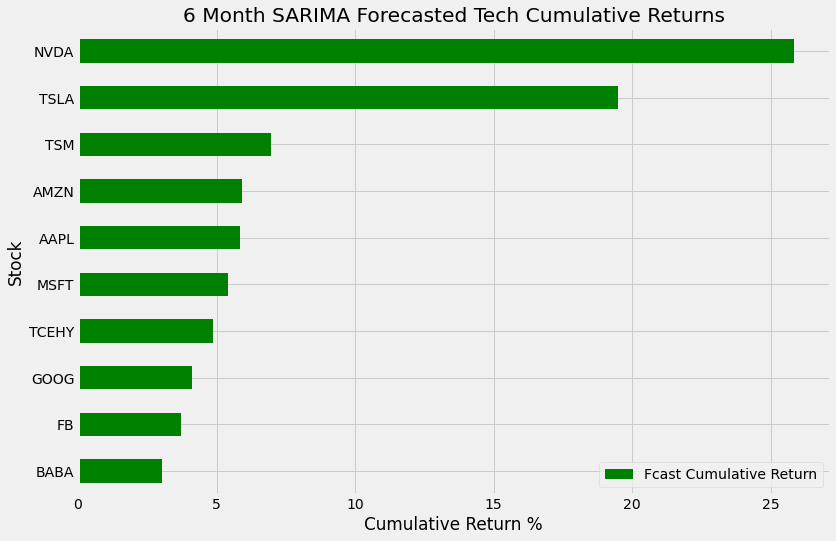

In [146]:
sarima_model_fcast(tech_df, '6 Month SARIMA Forecasted Tech Cumulative Returns', 'g')

### Healthcare SARIMA Models

In [93]:
healthcare_fcast = sarima_fcast_df(healthcare_df)
healthcare_fcast

,Stock,Fcast Cumulative Return
0,BIO,5.17
1,HCA,4.16
2,UNH,4.01
3,PKI,3.09
4,TDOC,2.74
5,CERN,1.42
6,MCK,1.13
7,ABC,1.11
8,CVS,1.01
9,CAH,0.66


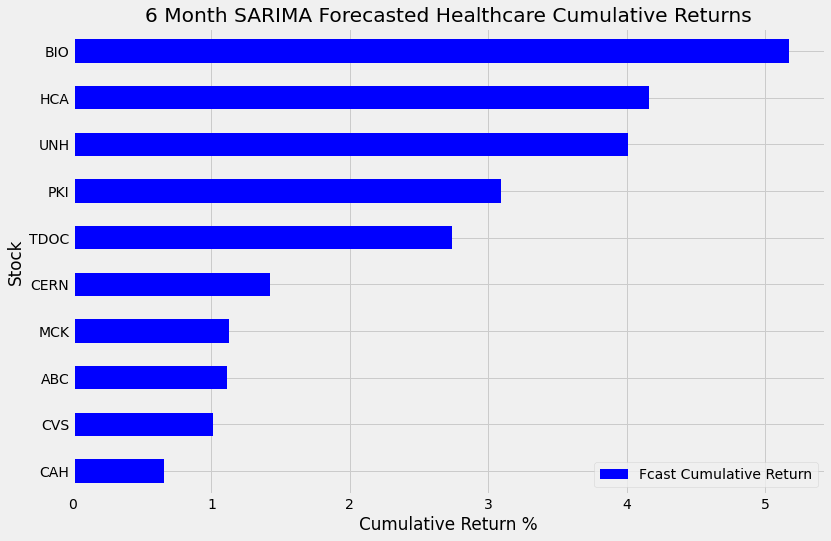

In [147]:
sarima_model_fcast(healthcare_df, '6 Month SARIMA Forecasted Healthcare Cumulative Returns', 'b')

### Crypto SARIMA Models

In [95]:
crypto_fcast = sarima_fcast_df(crypto_df)
crypto_fcast

,Stock,Fcast Cumulative Return
0,DOGE-USD,4534.25
1,ETH-USD,3561.64
2,XRP-USD,147.25
3,BTC-USD,122.41
4,LTC-USD,56.59


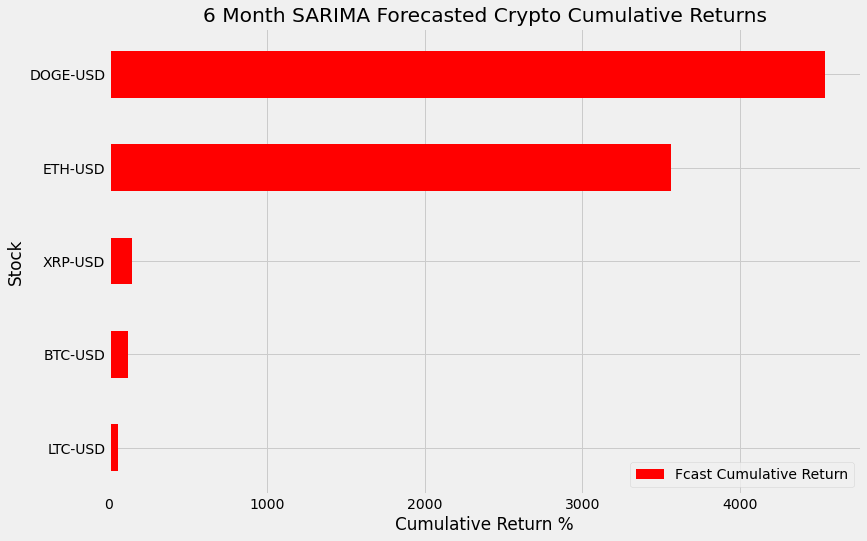

In [148]:
sarima_model_fcast(crypto_df, '6 Month SARIMA Forecasted Crypto Cumulative Returns', 'r')

### SARIMA Models Forecast Comparison

In [188]:
to_concat = [tech_fcast, healthcare_fcast, crypto_fcast]
fcast_comparison = pd.concat(to_concat)
fcast_comparison.reset_index(drop=True, inplace=True)
fcast_comparison.sort_values(by='Fcast Cumulative Return', ascending=False).reset_index(drop=True)

,Stock,Fcast Cumulative Return
0,DOGE-USD,4534.25
1,ETH-USD,3561.64
2,XRP-USD,147.25
3,BTC-USD,122.41
4,LTC-USD,56.59
5,NVDA,25.83
6,TSLA,19.48
7,TSM,6.98
8,AMZN,5.93
9,AAPL,5.84


In [98]:
merged_df = returns_comparison.merge(fcast_comparison, on='Stock', how='outer')
merged_df.rename(columns = {'Cumulative Return':'Past 5 yr Cumulative Return', 'Fcast Cumulative Return':'SARIMA 6 Month Fcast'}, inplace = True)

In [99]:
merged_df.head()

,Stock,Past 5 yr Cumulative Return,SARIMA 6 Month Fcast
0,NVDA,20.10,25.83
1,TSLA,13.96,19.48
2,TSM,5.36,6.98
3,AMZN,5.05,5.93
4,AAPL,4.72,5.84


### Training Data vs. Actual Data Graphs

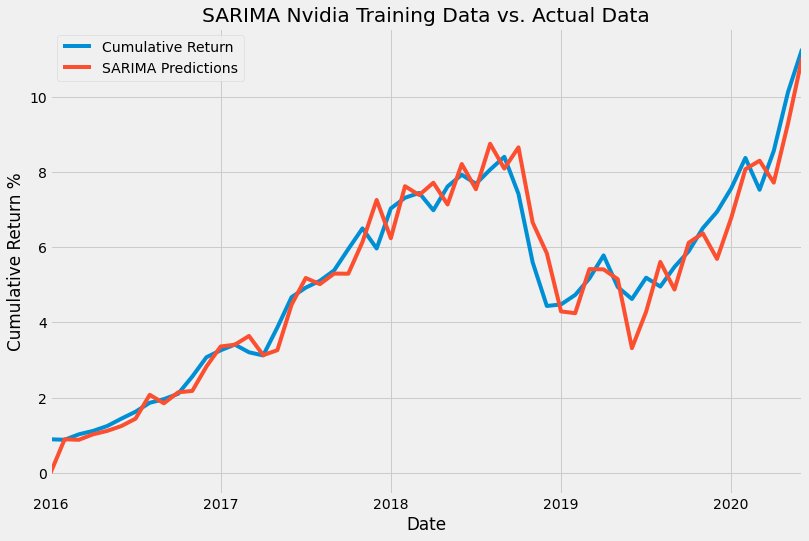

In [149]:
plot_train_pred(nvidia, 'SARIMA Nvidia Training Data vs. Actual Data')

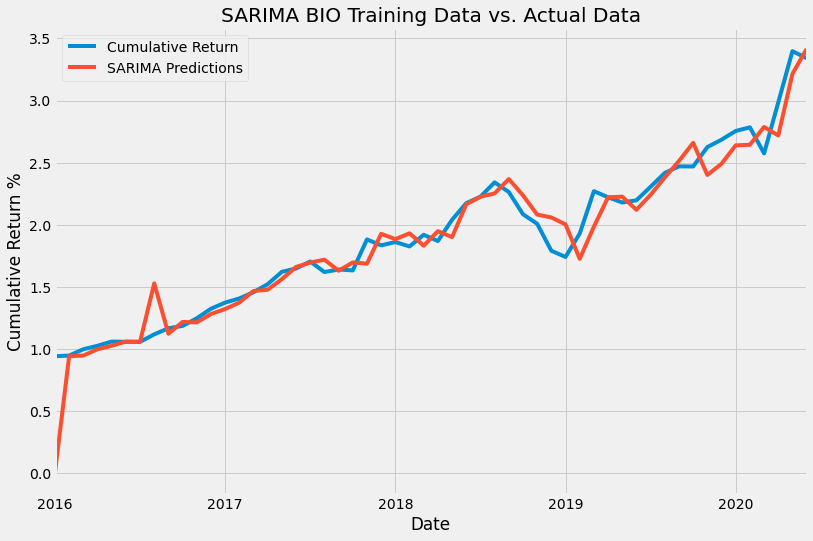

In [150]:
plot_train_pred(bio_rad, 'SARIMA BIO Training Data vs. Actual Data')

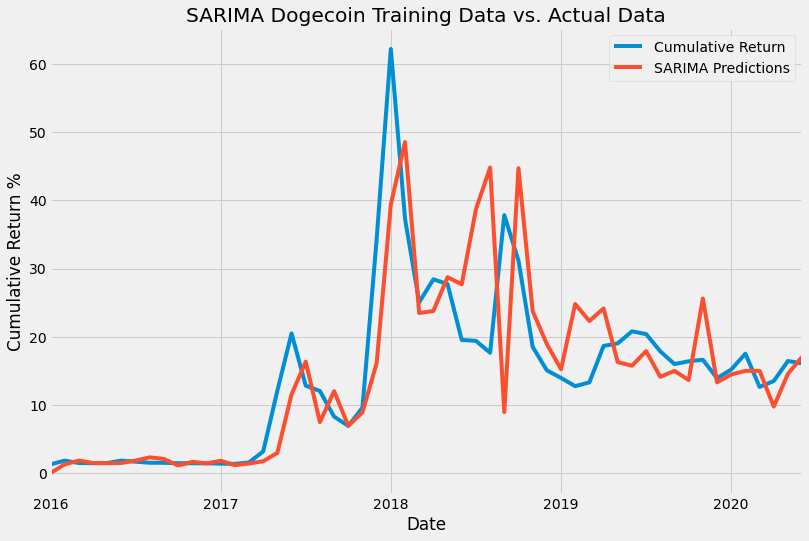

In [151]:
plot_train_pred(dogecoin, 'SARIMA Dogecoin Training Data vs. Actual Data')

### Test Data vs. Actual Data Graphs

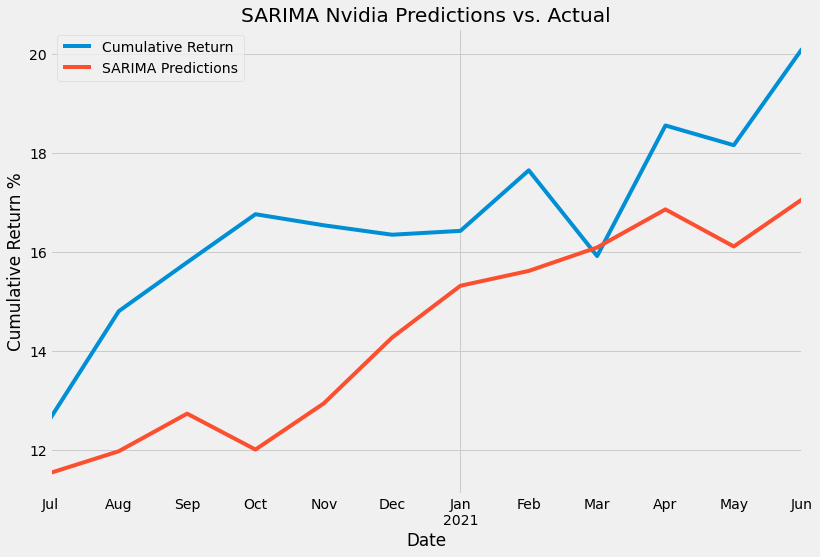

In [159]:
plot_test_pred(nvidia, 'SARIMA Nvidia Predictions vs. Actual')

#### RMSE vs. Test Data Mean

In [172]:
model_rmse(nvidia)

RMSE: 2.58 Test Mean: 16.63


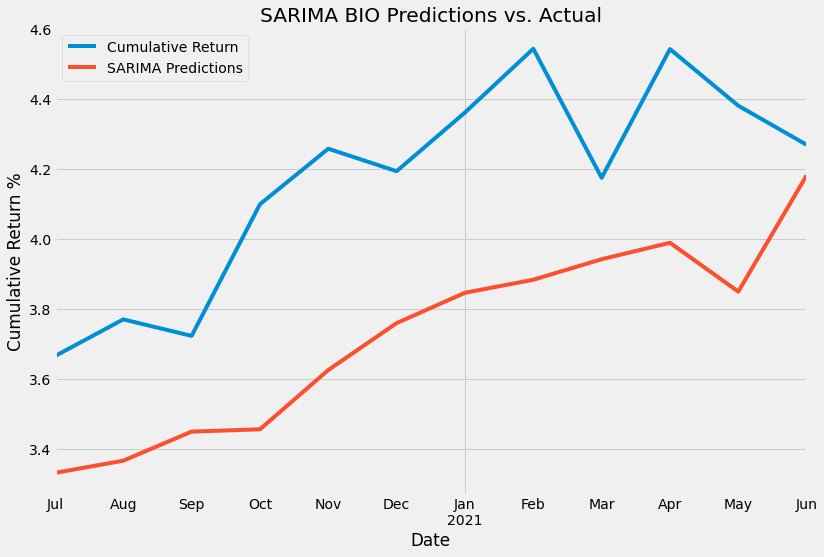

In [158]:
plot_test_pred(bio_rad, 'SARIMA BIO Predictions vs. Actual')

#### RMSE vs. Test Data Mean

In [173]:
model_rmse(bio_rad)

RMSE: 0.47 Test Mean: 4.17


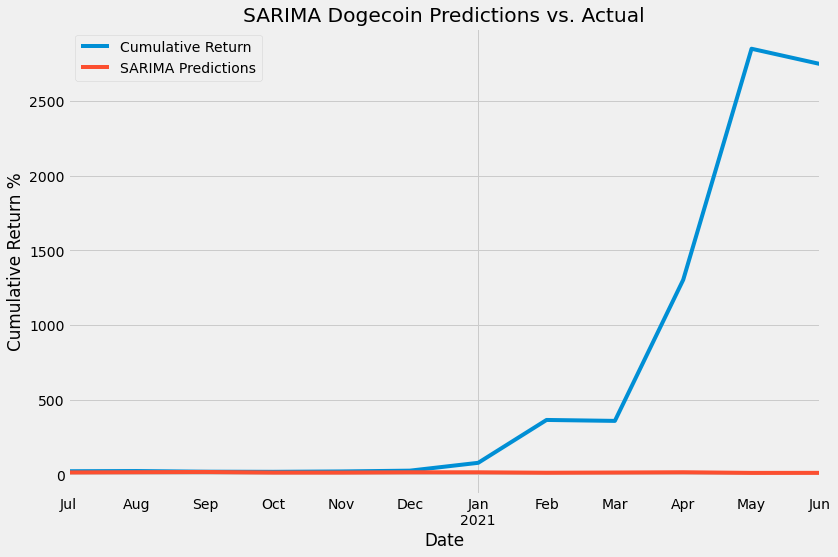

In [157]:
plot_test_pred(dogecoin, 'SARIMA Dogecoin Predictions vs. Actual')

#### RMSE vs. Test Data Mean

In [174]:
model_rmse(dogecoin)

RMSE: 1207.13 Test Mean: 652.15


### 6 Month SARIMA Forecast Graphs

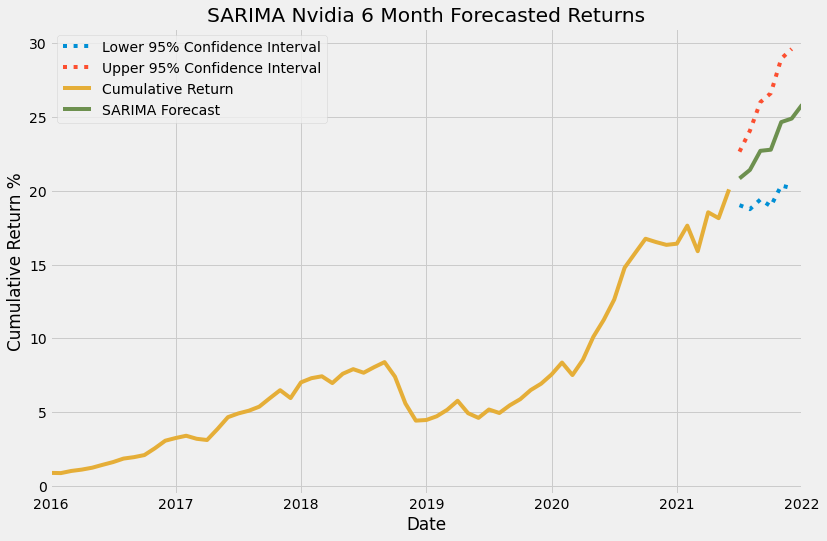

In [156]:
plot_fcast(nvidia, 'SARIMA Nvidia 6 Month Forecasted Returns')

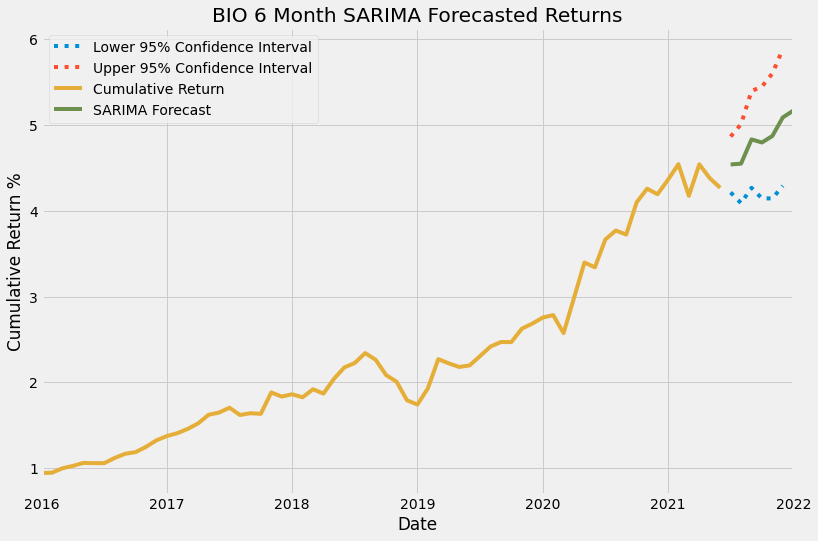

In [110]:
plot_fcast(bio_rad, 'BIO 6 Month SARIMA Forecasted Returns')

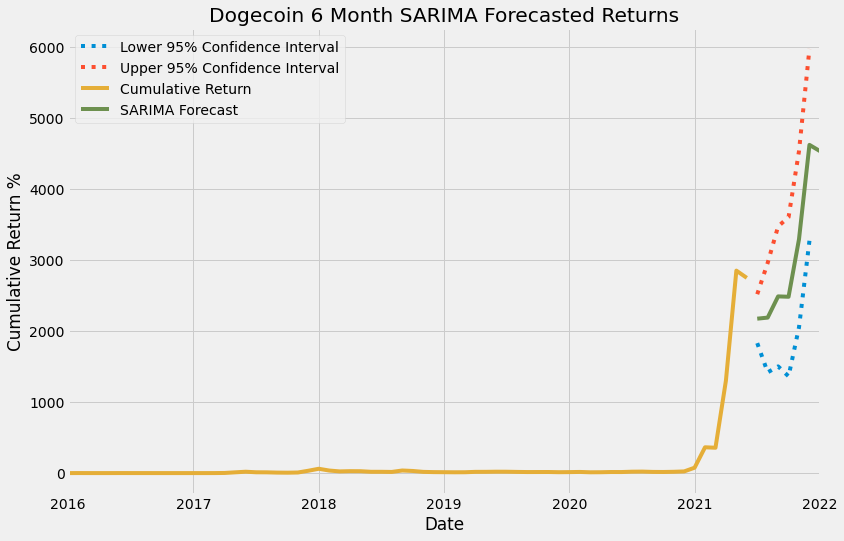

In [111]:
plot_fcast(dogecoin, 'Dogecoin 6 Month SARIMA Forecasted Returns')

### Facebook Prophet Models

 - Will run a Facebook Prophet model on each stock in order to get 6 month forecasted predictions and compare to previous SARIMA models.

### FB Tech Stock Models

In [112]:
tech_prophet_df = fb_prophet_df(tech_df)
tech_prophet_df

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,Stock,Prophet Fcast Cumulative Return
0,NVDA,10.56
1,MSFT,4.60
2,AMZN,4.15
3,AAPL,3.68
4,BABA,2.81
5,TSM,2.80
6,TCEHY,2.63
7,TSLA,2.53
8,FB,2.10
9,GOOG,2.08


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

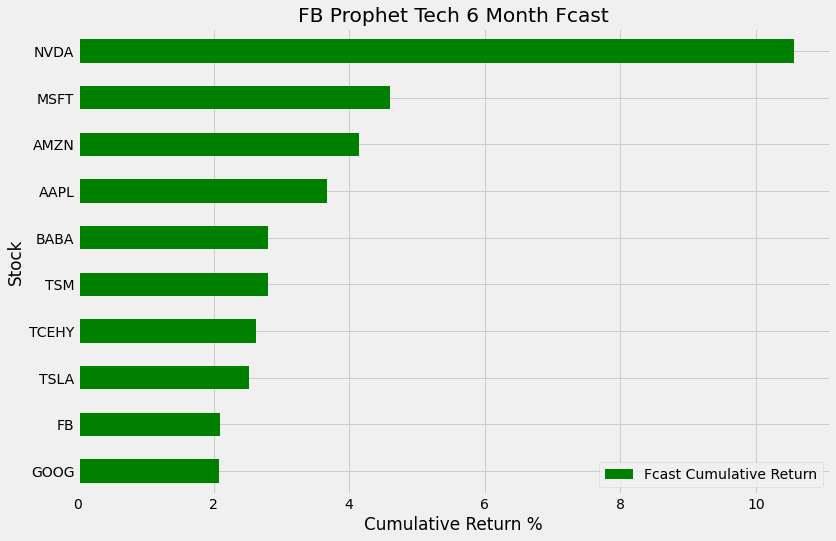

In [113]:
fb_prophet_model(tech_df, 'FB Prophet Tech 6 Month Fcast', 'g')

### FB Healthcare Stock Models

In [114]:
healthcare_prophet_df = fb_prophet_df(healthcare_df)
healthcare_prophet_df

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,Stock,Prophet Fcast Cumulative Return
0,TDOC,7.82
1,BIO,3.85
2,UNH,2.66
3,HCA,2.46
4,PKI,1.90
5,CERN,1.21
6,ABC,0.84
7,MCK,0.77
8,CVS,0.58
9,CAH,0.52


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

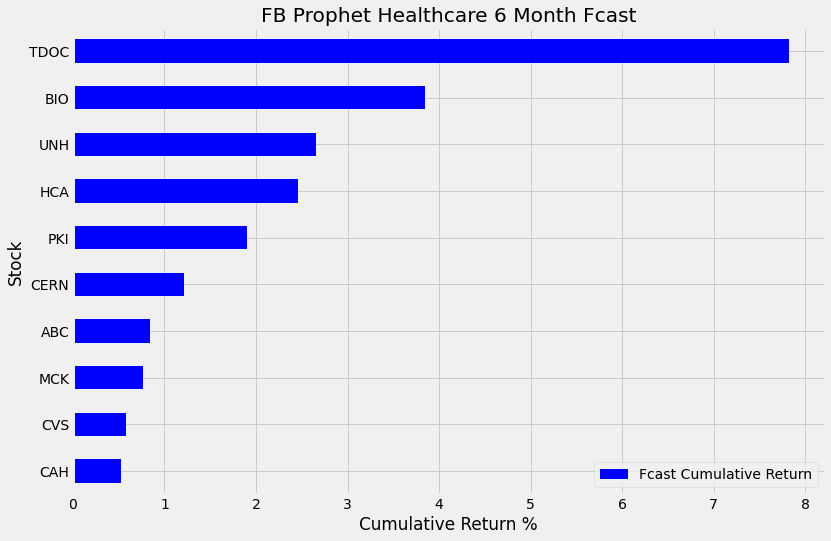

In [115]:
fb_prophet_model(healthcare_df, 'FB Prophet Healthcare 6 Month Fcast', 'b')

### FB Crypto Stock Models

In [116]:
crypto_prophet_df = fb_prophet_df(crypto_df)
crypto_prophet_df

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,Stock,Prophet Fcast Cumulative Return
0,ETH-USD,406.62
1,XRP-USD,101.34
2,LTC-USD,38.71
3,BTC-USD,33.88
4,DOGE-USD,31.89


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

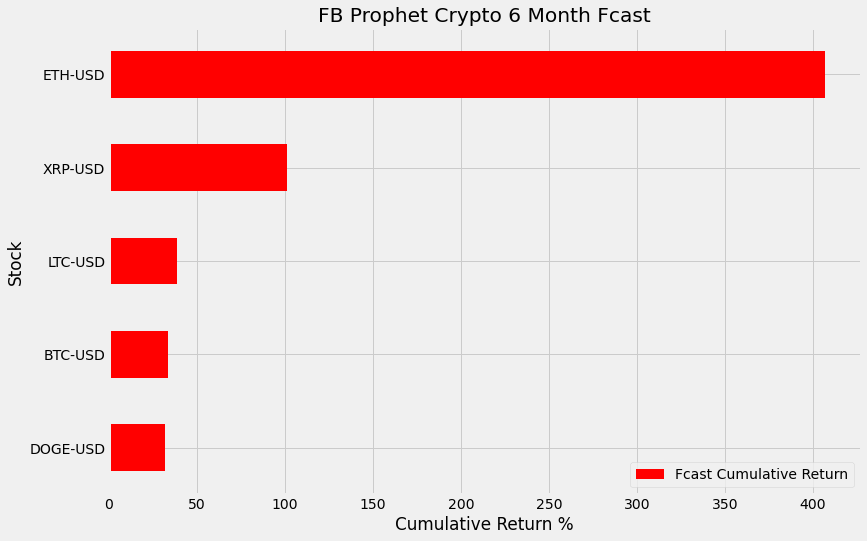

In [117]:
fb_prophet_model(crypto_df, 'FB Prophet Crypto 6 Month Fcast', 'r')

### Nvidia FB Graphs

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


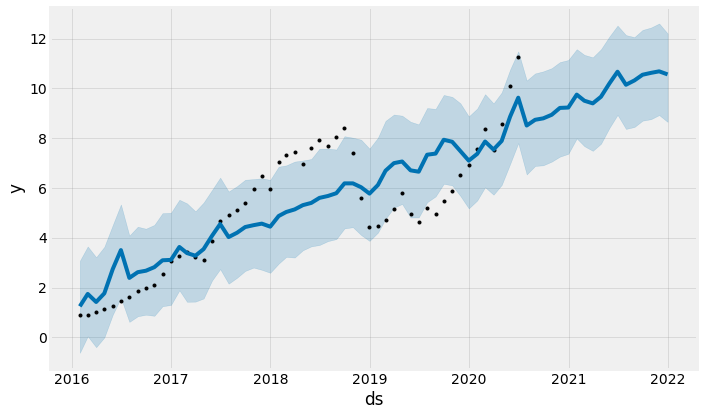

In [118]:
plot_prophet_fcast(nvidia)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


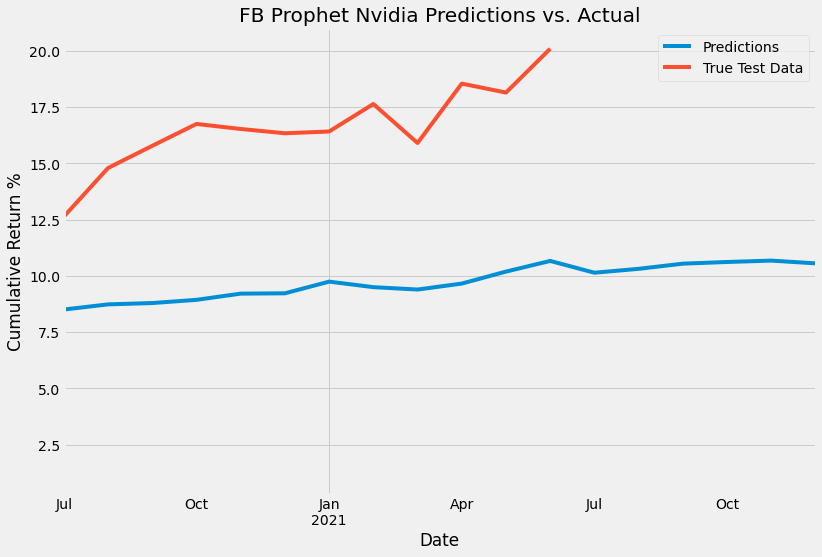

In [119]:
plot_prophet_test_fcast(nvidia, 'FB Prophet Nvidia Predictions vs. Actual')

#### RMSE vs. Test Data Mean

In [175]:
prophet_rmse(nvidia)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 6.65 Test Mean: 16.63


### Teladoc Health FB Graphs

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


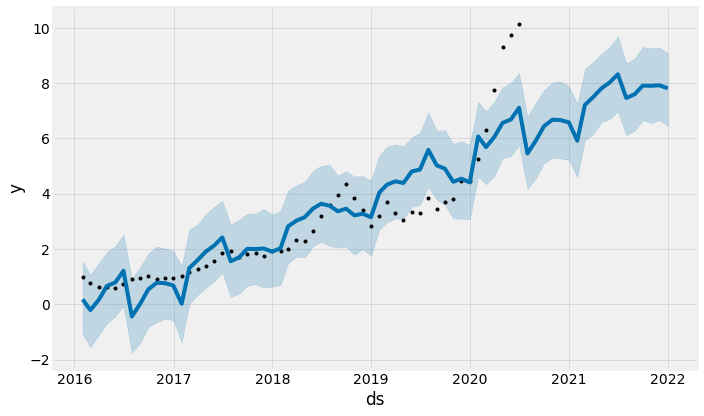

In [121]:
plot_prophet_fcast(teladoc_health)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


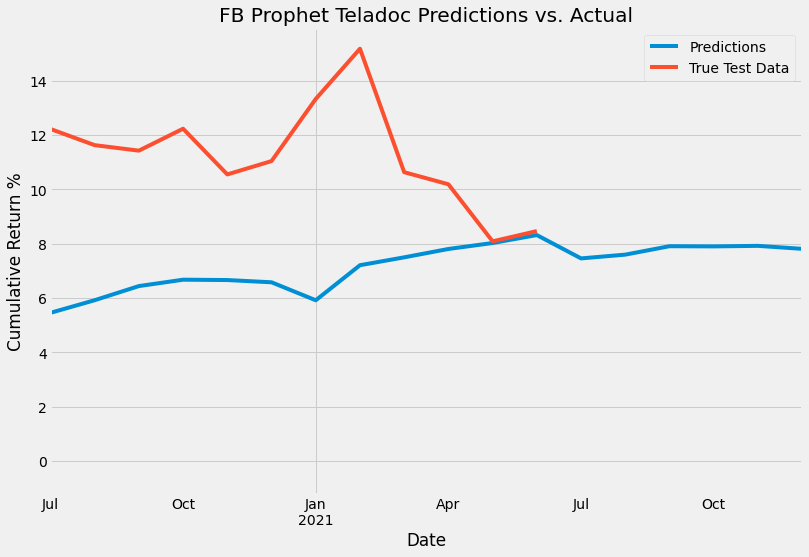

In [122]:
plot_prophet_test_fcast(teladoc_health, 'FB Prophet Teladoc Predictions vs. Actual')

#### RMSE vs. Test Data Mean

In [176]:
prophet_rmse(teladoc_health)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 4.22 Test Mean: 11.25


### Ethereum FB Graphs

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


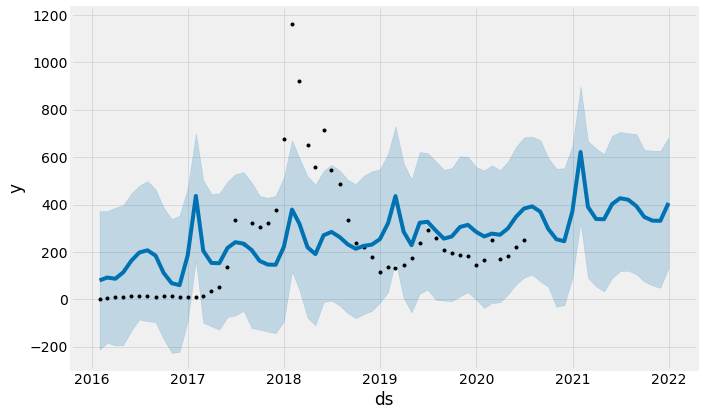

In [124]:
plot_prophet_fcast(ethereum)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


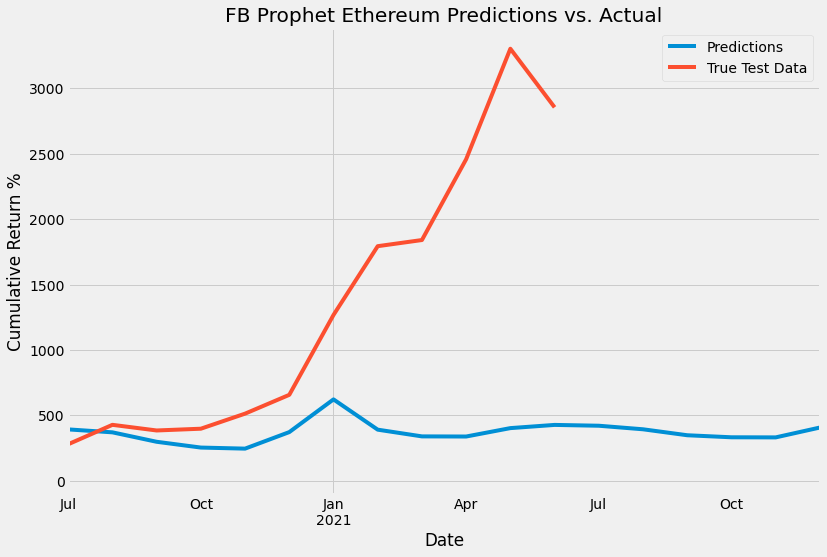

In [125]:
plot_prophet_test_fcast(ethereum, 'FB Prophet Ethereum Predictions vs. Actual')

#### RMSE vs. Test Data Mean

In [177]:
prophet_rmse(ethereum)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 1426.84 Test Mean: 1347.68


### FB Models Comparison

In [127]:
to_concat = [tech_prophet_df, healthcare_prophet_df, crypto_prophet_df]
prophet_models_df = pd.concat(to_concat)
prophet_models_df.reset_index(drop=True, inplace=True)
prophet_models_df.head()

,Stock,Prophet Fcast Cumulative Return
0,NVDA,10.56
1,MSFT,4.60
2,AMZN,4.15
3,AAPL,3.68
4,BABA,2.81


## Models Comparison/Final Analysis

In [189]:
models_comparison = merged_df.merge(prophet_models_df, on='Stock', how='outer')
models_comparison.rename(columns={'Prophet Fcast Cumulative Return':'Prophet 6 Month Fcast'},inplace=True)
col = models_comparison.loc[: , 'SARIMA 6 Month Fcast':'Prophet 6 Month Fcast']
models_comparison['SARIMA/Prophet Model Average Fcast'] = col.mean(axis=1)
models_comparison.sort_values(by='SARIMA/Prophet Model Average Fcast', ascending=False).reset_index(drop=True)

,Stock,Past 5 yr Cumulative Return,SARIMA 6 Month Fcast,Prophet 6 Month Fcast,SARIMA/Prophet Model Average Fcast
0,DOGE-USD,2749.18,4534.25,31.89,2283.070
1,ETH-USD,2854.49,3561.64,406.62,1984.130
2,XRP-USD,172.02,147.25,101.34,124.295
3,BTC-USD,86.51,122.41,33.88,78.145
4,LTC-USD,53.37,56.59,38.71,47.650
5,NVDA,20.10,25.83,10.56,18.195
6,TSLA,13.96,19.48,2.53,11.005
7,TDOC,8.47,2.74,7.82,5.280
8,AMZN,5.05,5.93,4.15,5.040
9,MSFT,4.51,5.43,4.60,5.015


### Volitility Analysis

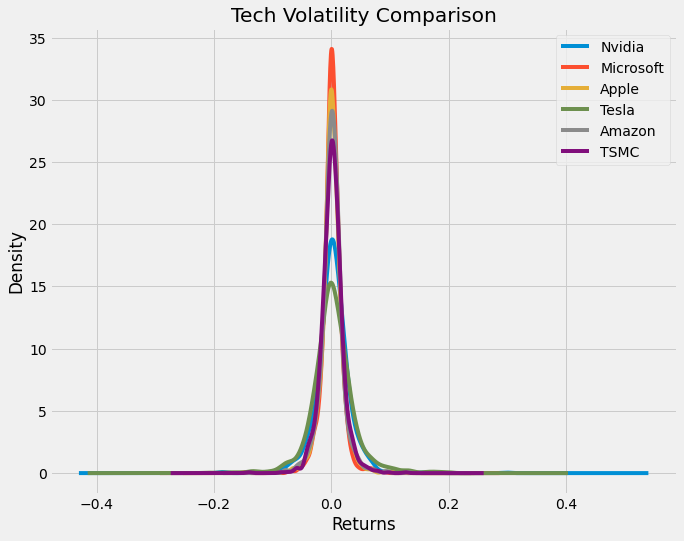

In [184]:
nvidia['Returns'].plot(kind='kde', label='Nvidia', figsize=(10,8))
microsoft['Returns'].plot(kind='kde', label='Microsoft', figsize=(10,8))
apple['Returns'].plot(kind='kde', label='Apple', figsize=(10,8))
tesla['Returns'].plot(kind='kde', label='Tesla', figsize=(10,8))
amazon['Returns'].plot(kind='kde', label='Amazon', figsize=(10,8))
tsmc['Returns'].plot(kind='kde', label='TSMC', figsize=(10,8))
plt.title('Tech Volatility Comparison')
plt.xlabel('Returns')
plt.legend();

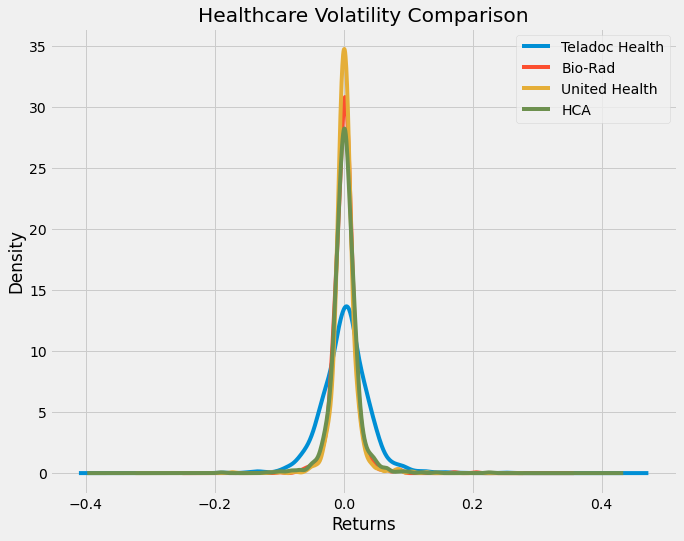

In [183]:
teladoc_health['Returns'].plot(kind='kde', label='Teladoc Health', figsize=(10,8))
bio_rad['Returns'].plot(kind='kde', label='Bio-Rad', figsize=(10,8))
united_health['Returns'].plot(kind='kde', label='United Health', figsize=(10,8))
hca['Returns'].plot(kind='kde', label='HCA', figsize=(10,8))
plt.title('Healthcare Volatility Comparison')
plt.xlabel('Returns')
plt.legend();

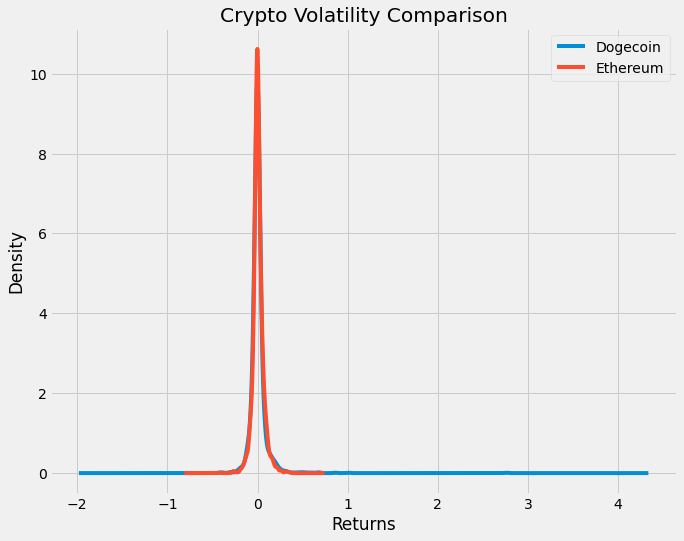

In [182]:
dogecoin['Returns'].plot(kind='kde', label='Dogecoin', figsize=(10,8))
ethereum['Returns'].plot(kind='kde', label='Ethereum', figsize=(10,8))
plt.title('Crypto Volatility Comparison')
plt.xlabel('Returns')
plt.legend();

### P/E Ratio Analysis

In [132]:
get_pe_ratio('NVDA')

attribute    PE Ratio (TTM)
value                 84.26
Name: 13, dtype: object

In [133]:
get_pe_ratio('TSLA')

attribute    PE Ratio (TTM)
value                604.76
Name: 13, dtype: object

In [134]:
get_pe_ratio('AMZN')

attribute    PE Ratio (TTM)
value                 64.81
Name: 13, dtype: object

In [135]:
get_pe_ratio('MSFT')

attribute    PE Ratio (TTM)
value                 35.26
Name: 13, dtype: object

In [136]:
get_pe_ratio('TSM')

attribute    PE Ratio (TTM)
value                 31.39
Name: 13, dtype: object

In [137]:
get_pe_ratio('AAPL')

attribute    PE Ratio (TTM)
value                 29.31
Name: 13, dtype: object

In [138]:
get_pe_ratio('TDOC')

attribute    PE Ratio (TTM)
value                   NaN
Name: 13, dtype: object

In [139]:
get_pe_ratio('BIO')

attribute    PE Ratio (TTM)
value                  4.51
Name: 13, dtype: object

In [140]:
get_pe_ratio('UNH')

attribute    PE Ratio (TTM)
value                 22.79
Name: 13, dtype: object

In [141]:
get_pe_ratio('HCA')

attribute    PE Ratio (TTM)
value                 15.57
Name: 13, dtype: object

 - Based on the above models comparison chart, because DOGE is so far apart between the two model predictions I would recommend avoiding this stock and instead choosing ETH for the portfolio as the cryptocurrency stock. While ETH is still far apart between models, it still has a forecasted cumulative return of 407% on the low end compared to just 32% for DOGE. 
 
 
 - For Tech stock recommendations although NVDA and TSLA, have the highest average forecast among tech stocks, they both have high P/E ratios and tend to be more volitile as seen in the analysis below. Because of these two factors I would recommend avoiding these stocks and instead choose MSFT, AAPl, and TSM as the three tech stock recommendations as these stocks feature much lower P/E ratios and tend to be more stable in terms of volitility. 
 
 
 - For the healthcare sector I would recommend BIO, UNH, and HCA, as these stocks appear to be relatively stable in terms of volitility and all feature P/E ratios within a good range. Although TDOC has the highest forecasted predictions among the models, it also tends to be much more volitile and does not report a P/E ratio. For these reasons I would recommend avoiding this stock.  

## Portfolio Recommendations/Conclusion

 - Top 3 Tech Stocks to invest in:
     1. Microsoft
     2. Apple
     3. TSMC
     
     
 - Top 3 Healthcare Stocks to invest in:
     1. Bio-Rad
     2. United Health
     3. HCA
     
     
 - Top Cryptocurrency to invest in:
     1. Ethereum

 - Overall the above stocks all feature good model predictions, tend to be less volitile compared to other stocks in their sector, and have P/E ratios within a decent range. Taking all these factors into account this would be my final portfolio recommendation for the next 6 month period.

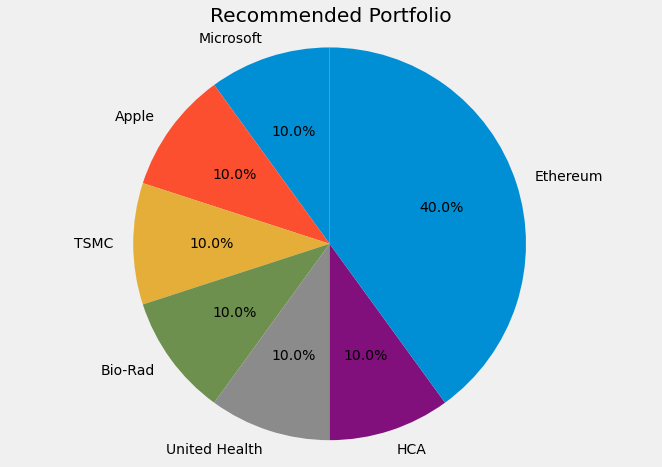

In [220]:
labels = 'Microsoft', 'Apple', 'TSMC', 'Bio-Rad', 'United Health', 'HCA', 'Ethereum'
sizes = [10, 10, 10, 10, 10, 10, 40]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
fig1.subplots_adjust(0.5,1,2,2.5)
ax1.axis('equal')
fig.tight_layout()
plt.title('Recommended Portfolio')
plt.show()

## Future Work